# this notebook parse patch data
# TODO: meet with Venu to confirm the changes I made
# TODO: figure out the units in COSMED

In [1]:
import numpy as np
import argparse

import os
import math
from math import sin

import pandas as pd
from sklearn.linear_model import LinearRegression


import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
matplotlib.rc( 'savefig', facecolor = 'white' )
from matplotlib import pyplot
%matplotlib inline

i_seed = 0

import sys
sys.path.append('../') # add this line so Data and data are visible in this file
sys.path.append('../../') # add this line so Data and data are visible in this file
sys.path.append('../PatchWand/') # add this line so Data and data are visible in this file

# from PatchWand import *
from filters import *
from setting import *
from plotting_tools import *
from stage1_patch import *
from TimeStampReader import *
from Subject import *
from PatchParser import *
from preprocessing import *
from ECG_module import *
from PPG_module import *
from segmentation import *
from stage3_preprocess import *


from importlib import reload
%load_ext autoreload
%autoreload 2

In [2]:
label_range_dict

{'ppg': [-100, 100],
 'acc': [-2, 2],
 'ecg': [-5, 5],
 'RR': [5, 100],
 'HR': [40, 180],
 'rer': [0.4, 1.0],
 'vevco2_slope': [20, 50],
 'VT': [1, 10000],
 'SPO2': [70, 100],
 'width_QRS': 0.15,
 'VE': [0, 200],
 'VO2': [0, 6000],
 'VCO2': [0, 6000],
 'EE': [0, 30000],
 'GpsAlt': [1, 2000],
 'AmbTemp': [-10, 35]}

In [3]:
parser = argparse.ArgumentParser(description='SpO2_estimate')
parser.add_argument('--input_folder', metavar='input_folder', help='input_folder',
                    default='../')
parser.add_argument('--output_folder', metavar='output_folder', help='output_folder',
                    default='../')
parser.add_argument('--log_wandb', metavar='log_wandb', help='log_wandb',
                    default=True)
parser.add_argument('--ignore_past', metavar='ignore_past', help='ignore_past',
                    default=False)


# checklist 3: comment first line, uncomment second line
args = parser.parse_args(['--input_folder', '../../data/stage2/', 
                          '--output_folder', '../../data/stage3/',
                         ])
# args = parser.parse_args()
print(args)

Namespace(ignore_past=False, input_folder='../../data/stage2/', log_wandb=True, output_folder='../../data/stage3/')


In [4]:
subject_id = 'sub102'

In [5]:
inputdir = args.input_folder
outputdir = args.output_folder

if not os.path.exists(outputdir):
    os.makedirs(outputdir)
    
outputdir_sub = outputdir+subject_id

if not os.path.exists(outputdir_sub):
    os.makedirs(outputdir_sub)
    

# get sync data

In [26]:
inputdir_sub = inputdir+subject_id+'/'
for syn_file in os.listdir(inputdir_sub):
#     print(inputdir_sub+syn_file)
    df_sync = pd.read_feather(inputdir_sub+syn_file)

#     if 'sub' in sub_file:
#         for data_file in os.listdir(inputdir+sub_file):
#             df_sync = pd.read_feather(inputdir+sub_file+'/'+data_file) 


In [27]:
# sub_file .

In [28]:
list(df_sync.columns)

['HR_cosmed',
 'RR_cosmed',
 'VT_cosmed',
 'VE_cosmed',
 'VO2_cosmed',
 'VCO2_cosmed',
 'EE_cosmed',
 'SPO2_cosmed',
 'GpsAlt_cosmed',
 'AmbTemp_cosmed',
 'Battery_cosmed',
 'time',
 'Marker_cosmed',
 'task',
 'Sampled_cosmed',
 'ECG',
 'accelX',
 'accelY',
 'accelZ',
 'ppg_g_1',
 'ppg_r_1',
 'ppg_ir_1',
 'ppg_g_2',
 'ppg_r_2',
 'ppg_ir_2',
 'temp_skin',
 'pres']

In [29]:
Fs = FS_RESAMPLE

In [30]:
# FILT_PPG, FILT_SCG, FILT_ECG

In [31]:
unit_dict

{'accel': 'g',
 'ppg': 'uW',
 'temp': 'Celsius',
 'pres': 'mbar',
 'ecg': 'mV',
 'HR': 'b(eats)pm',
 'RR': 'b(reaths)pm',
 'VT': 'ml/breath',
 'VE': 'L/min',
 'VO2': 'ml/min',
 'VCO2': 'ml/min',
 'EE': 'kcals/min',
 'SPO2': '%'}

In [32]:
df_sync

,HR_cosmed,RR_cosmed,VT_cosmed,VE_cosmed,VO2_cosmed,VCO2_cosmed,EE_cosmed,SPO2_cosmed,GpsAlt_cosmed,AmbTemp_cosmed,Battery_cosmed,time,Marker_cosmed,task,Sampled_cosmed,ECG,accelX,accelY,accelZ,ppg_g_1,ppg_r_1,ppg_ir_1,ppg_g_2,ppg_r_2,ppg_ir_2,temp_skin,pres
0,81.8008,21.02372,426.0208,9.11732,297.6588,225.8964,1.423521,97.5996,316.0,23.6,91.0,0.004,1.0,Transition,1.0,-0.024717,-0.183319,0.967941,0.261605,22630.360825,326.184967,18062.247968,22524.499099,1702.790447,17397.700614,33.031226,981.381591
1,81.8016,21.02744,425.8416,9.11464,297.5176,225.7928,1.422849,97.5992,316.0,23.6,91.0,0.008,0.0,Transition,0.0,-0.022181,-0.278272,0.951678,0.237106,22788.863978,327.882535,18166.080129,22537.166620,1697.458651,17402.859827,33.031266,981.381600
2,81.8024,21.03116,425.6624,9.11196,297.3764,225.6892,1.422178,97.5988,316.0,23.6,91.0,0.012,0.0,Transition,0.0,-0.241229,-0.638516,-0.411547,-2.048000,22947.367132,329.580102,18269.912291,22549.834141,1692.126856,17408.019040,33.031306,981.381610
3,81.8032,21.03488,425.4832,9.10928,297.2352,225.5856,1.421507,97.5984,316.0,23.6,91.0,0.016,0.0,Transition,0.0,-0.461085,1.993307,2.019372,2.047996,23053.104070,330.198049,18345.073201,22581.411859,1686.476375,17427.928934,33.031346,981.381619
4,81.8040,21.03860,425.3040,9.10660,297.0940,225.4820,1.420835,97.5980,316.0,23.6,91.0,0.020,0.0,Transition,0.0,-0.066609,-1.904348,0.366494,1.055751,23054.307067,328.677188,18363.434150,22650.452137,1680.194555,17477.061064,33.031386,981.381628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972745,84.3888,25.98192,476.9440,12.45360,203.3376,280.8272,1.112868,96.0000,304.0,20.0,70.0,3890.984,0.0,Recovery 4,0.0,0.491670,-0.102986,1.006286,-0.114998,23612.445155,229.717391,18560.826907,22503.347617,1389.279734,11951.347975,34.095000,981.009885
972746,84.3916,25.97644,476.9080,12.45020,203.3032,280.7704,1.112670,96.0000,304.0,20.0,70.0,3890.988,0.0,Recovery 4,0.0,0.486358,-0.102595,1.005405,-0.116395,23611.059857,229.486136,18558.459530,22502.239379,1388.539718,11950.233916,34.095000,981.009881
972747,84.3944,25.97096,476.8720,12.44680,203.2688,280.7136,1.112471,96.0000,304.0,20.0,70.0,3890.992,0.0,Recovery 4,0.0,0.480262,-0.102539,1.004005,-0.118064,23610.433404,229.434486,18556.521502,22501.319157,1388.005790,11949.295003,34.095000,981.009877
972748,84.3972,25.96548,476.8360,12.44340,203.2344,280.6568,1.112273,96.0000,304.0,20.0,70.0,3890.996,0.0,Recovery 4,0.0,0.469020,-0.102400,1.003042,-0.118571,23609.924156,229.410576,18554.649787,22500.427974,1387.503693,11948.383142,34.095000,981.009874


In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# get a small segment of the sync signal

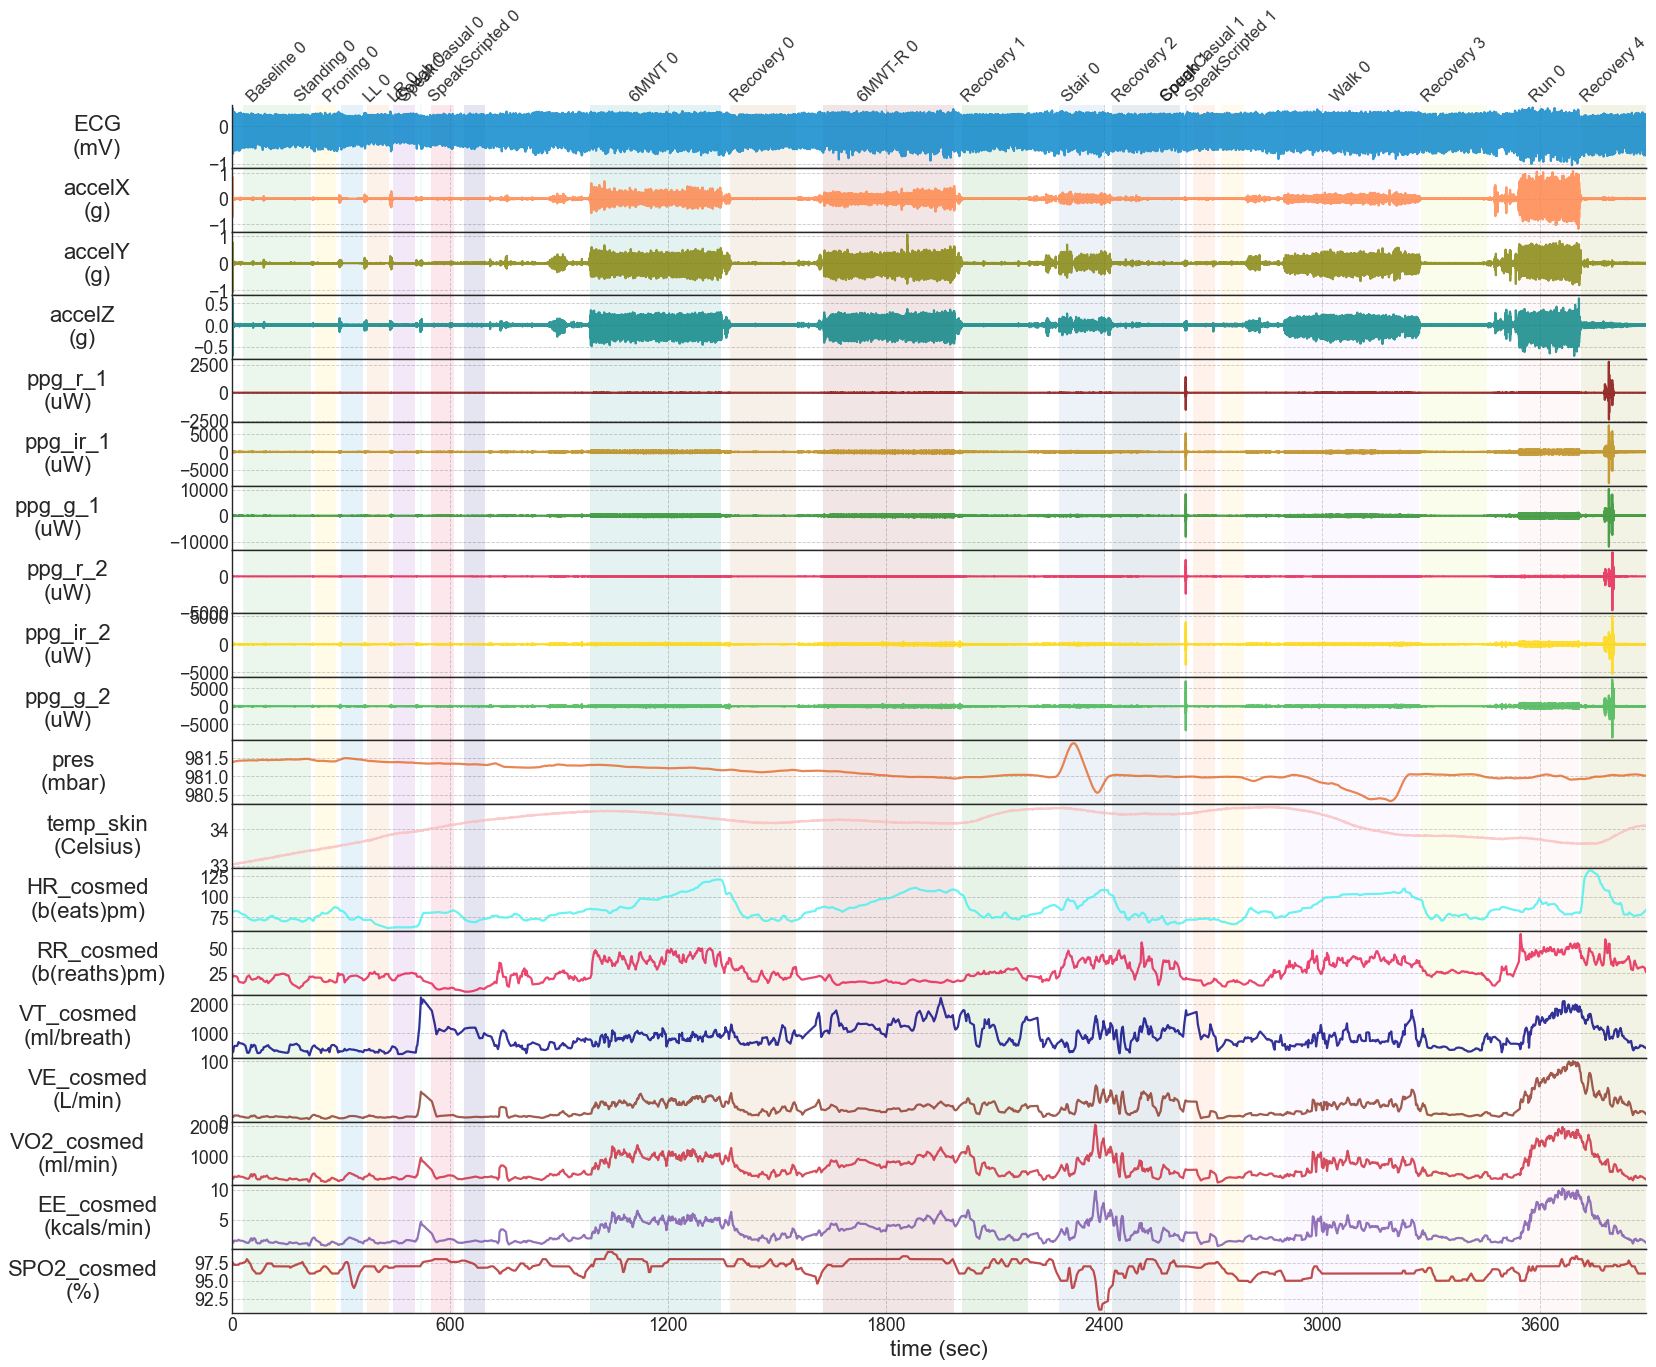

In [34]:
# define range
t_start = 0
t_end = t_start+5000

# get a copy of data in this range
df = get_filt_df(df_sync, Fs).copy()
df = df[(df['time'] >= t_start) & (df['time'] <= t_end)]

# downsample it to make plotting quicker
downsample_factor = 5
df = df[df.index%downsample_factor==0]

# plot the signals
plt_scale = 1.2
plot_all_sync(df, subject_id, plt_scale=plt_scale, outputdir=outputdir, show_plot=True)


In [35]:
unit_dict

{'accel': 'g',
 'ppg': 'uW',
 'temp': 'Celsius',
 'pres': 'mbar',
 'ecg': 'mV',
 'HR': 'b(eats)pm',
 'RR': 'b(reaths)pm',
 'VT': 'ml/breath',
 'VE': 'L/min',
 'VO2': 'ml/min',
 'VCO2': 'ml/min',
 'EE': 'kcals/min',
 'SPO2': '%'}

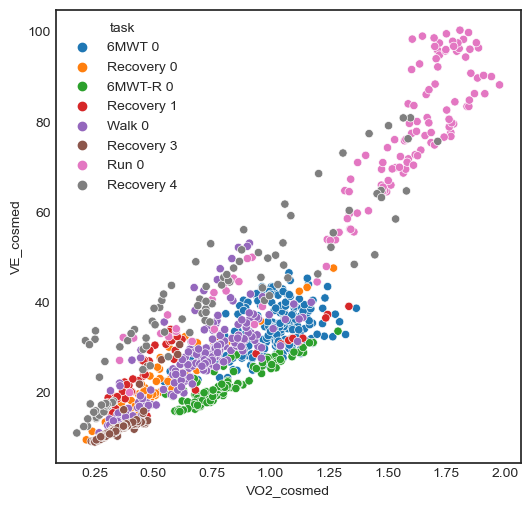

In [25]:
import seaborn as sns

df = df_sync[df_sync['Sampled_cosmed']==1].copy()
df['VO2_cosmed'] = df['VO2_cosmed']/1000
df = df[df['task']!='Transition']
df = df[(df['task']=='6MWT 0') | (df['task']=='6MWT-R 0') | (df['task']=='Recovery 0') | (df['task']=='Recovery 1') | (df['task']=='Walk 0') | (df['task']=='Recovery 3')| (df['task']=='Run 0') | (df['task']=='Recovery 4')]

fig, ax = plt.subplots(1,1,figsize=(6,6), dpi=100)

sns.scatterplot(data=df, x="VO2_cosmed", y="VE_cosmed", hue="task", ax=ax)


#     if outputdir is not None:
        
# if fig_name is None:
fig_name = '/VO2_VE'

fig.savefig(outputdir_sub + fig_name+'.png', transparent=False)


In [20]:
df_sync['']

,HR_cosmed,RR_cosmed,VT_cosmed,VE_cosmed,VO2_cosmed,VCO2_cosmed,EE_cosmed,SPO2_cosmed,GpsAlt_cosmed,AmbTemp_cosmed,Battery_cosmed,time,Marker_cosmed,task,Sampled_cosmed,ECG,accelX,accelY,accelZ,ppg_g_1,ppg_r_1,ppg_ir_1,ppg_g_2,ppg_r_2,ppg_ir_2,temp_skin,pres
0,81.8008,21.02372,426.0208,9.11732,297.6588,225.8964,1.423521,97.5996,316.0,23.6,91.0,0.004,1.0,Transition,1.0,-0.024717,-0.183319,0.967941,0.261605,22630.360825,326.184967,18062.247968,22524.499099,1702.790447,17397.700614,33.031226,981.381591
1,81.8016,21.02744,425.8416,9.11464,297.5176,225.7928,1.422849,97.5992,316.0,23.6,91.0,0.008,0.0,Transition,0.0,-0.022181,-0.278272,0.951678,0.237106,22788.863978,327.882535,18166.080129,22537.166620,1697.458651,17402.859827,33.031266,981.381600
2,81.8024,21.03116,425.6624,9.11196,297.3764,225.6892,1.422178,97.5988,316.0,23.6,91.0,0.012,0.0,Transition,0.0,-0.241229,-0.638516,-0.411547,-2.048000,22947.367132,329.580102,18269.912291,22549.834141,1692.126856,17408.019040,33.031306,981.381610
3,81.8032,21.03488,425.4832,9.10928,297.2352,225.5856,1.421507,97.5984,316.0,23.6,91.0,0.016,0.0,Transition,0.0,-0.461085,1.993307,2.019372,2.047996,23053.104070,330.198049,18345.073201,22581.411859,1686.476375,17427.928934,33.031346,981.381619
4,81.8040,21.03860,425.3040,9.10660,297.0940,225.4820,1.420835,97.5980,316.0,23.6,91.0,0.020,0.0,Transition,0.0,-0.066609,-1.904348,0.366494,1.055751,23054.307067,328.677188,18363.434150,22650.452137,1680.194555,17477.061064,33.031386,981.381628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972745,84.3888,25.98192,476.9440,12.45360,203.3376,280.8272,1.112868,96.0000,304.0,20.0,70.0,3890.984,0.0,Recovery 4,0.0,0.491670,-0.102986,1.006286,-0.114998,23612.445155,229.717391,18560.826907,22503.347617,1389.279734,11951.347975,34.095000,981.009885
972746,84.3916,25.97644,476.9080,12.45020,203.3032,280.7704,1.112670,96.0000,304.0,20.0,70.0,3890.988,0.0,Recovery 4,0.0,0.486358,-0.102595,1.005405,-0.116395,23611.059857,229.486136,18558.459530,22502.239379,1388.539718,11950.233916,34.095000,981.009881
972747,84.3944,25.97096,476.8720,12.44680,203.2688,280.7136,1.112471,96.0000,304.0,20.0,70.0,3890.992,0.0,Recovery 4,0.0,0.480262,-0.102539,1.004005,-0.118064,23610.433404,229.434486,18556.521502,22501.319157,1388.005790,11949.295003,34.095000,981.009877
972748,84.3972,25.96548,476.8360,12.44340,203.2344,280.6568,1.112273,96.0000,304.0,20.0,70.0,3890.996,0.0,Recovery 4,0.0,0.469020,-0.102400,1.003042,-0.118571,23609.924156,229.410576,18554.649787,22500.427974,1387.503693,11948.383142,34.095000,981.009874


In [19]:

# def Pxx_segmentation(t_art, xx, i_peaks, start_offset=-50, end_offset=250):
#     # segment STFT matrix into sequences of smaller matrices
# #     seq_legnth = end_offset - start_offset

#     Pxx_seq = []
#     ts_Pxx_seq = []
    
#     for i, i_peak in enumerate(i_peaks):
#         i_start = int(i_peak + start_offset)
#         i_end = int(i_peak + end_offset)

#         if i_start < 0 or i_end > Pxx.shape[0]:
#             continue
#         Pxx_seq.append(Pxx[i_start:i_end, :])
#         ts_Pxx_seq.append(ts_Pxx[i_start:i_end])

#     Pxx_seq = np.stack(Pxx_seq)
#     # Pxx_seq.shape = (276, seq_len, N_feature)
#     # Pxx_seq = np.transpose(Pxx_seq, (0, 2, 1))
#     # Pxx_seq.shape = (276, N_feature, seq_len)

#     ts_Pxx_seq = np.stack(ts_Pxx_seq)
    
#     return ts_Pxx_seq, Pxx_seq

# 3. getting patch ECG beats and i_R_peaks
## make a dictionary to store the beats and plot them

In [17]:
# def get_IBI_max(i_beat_peaks):
#     hr = 1/ (np.diff(i_beat_peaks)/Fs) * 60
#     indices_CI = arg_CI(hr, confidence_interv=96)
#     # max window legnth such that the whole pulse can be captured but the next beat won't leak into the current beat
#     IBI_min = 1 / (hr[indices_CI].max()/60) * 1.2
#     return IBI_min

# functions for PPG DC

In [16]:
# def ppg_filter(sig_raw, highcutoff, Fs):

#     # get time vector
#     ts = np.arange(sig_raw.shape[0])/Fs
#     # DS from Fs to Fs/5 = 100Hz
#     downsample_factor = 5

#     # estiamte DS signal
#     Fs_DS = Fs / downsample_factor # 100 Hz
#     ts_DS = ts[::downsample_factor]
#     sig_DS = np.interp(ts_DS, ts, sig_raw)    

#     # use padded signal and filter
#     filter_padded = 1 # sec
#     offset = int(filter_padded*Fs) # reversely pad filter_padded sec to beginning and end of the signal
#     sig_DS = np.r_[sig_DS[0:offset][::-1], sig_DS, sig_DS[-offset:][::-1]]
#     sig_filt = butter_filter('low', sig_DS, highcutoff, Fs_DS)
    
#     # recover the filtered signal so it's legnth eqauls to that of sig_raw
#     sig_filt = sig_filt[offset:-offset]
#     sig_filt = np.interp(ts, ts_DS, sig_filt)  

#     return sig_filt

# def get_ppg_DC_dict(df, i_R_peaks, start_offset, end_offset):

#     ppg_DC_dict = {}

#     ppg_names = ['ppg_g_1', 'ppg_r_1', 'ppg_ir_1', 'ppg_g_2', 'ppg_r_2', 'ppg_ir_2']

#     for ppg_name in ppg_names:
#         ppg_DC = ppg_filter(df[ppg_name].values, highcutoff=R_highcutoff, Fs=Fs)
#         ppg_DC, _ = beat_segmentation(ppg_DC, i_R_peaks, start_offset=start_offset, end_offset=end_offset)
#         ppg_DC = ppg_DC.mean(axis=0)
#         ppg_DC_dict[ppg_name] = ppg_DC
        
#     return ppg_DC_dict

In [17]:
# for subject_id in df_subjects:
# #     if subject_id != '011':
# #         continue
#     df_sub = df_subjects[subject_id]

#     hr = df_sub['HR_biopac'].values
#     indices_CI = arg_CI(hr, confidence_interv=96)
#     IBI_min = 1 / (hr[indices_CI].max()/60) * 1.2
    
#     print(subject_id, hr[indices_CI].max(), IBI_min)

# detect R peaks

In [48]:

t_start = 0
# t_end = t_start+5000
# t_start = 1750
# t_end = t_start+500

# task_name = 'Recovery 3'
# task_name = '6MWT 0'

# task_name = 'Recovery 0'
task_name = 'Recovery 1'
task_name = '6MWT 0'
# task_name = 'Recovery 2'
# task_name = 'Recovery 3'
# task_name = 'Recovery 4'
# task_name = 'Walk 0'
# task_name = 'Run 0'

t_start = df_sync[df_sync['task']==task_name]['time'].min()
t_end = df_sync[df_sync['task']==task_name]['time'].max()

# t_start = 3987
# t_end = t_start+5
# t_start = 4000
# t_end = t_start+5
# t_start = 2500
# t_end = t_start+10


df = df_sync.copy()
# df = get_filt_df(df, Fs).copy()

df = df[(df['time'] >= t_start) & (df['time'] <= t_end)]

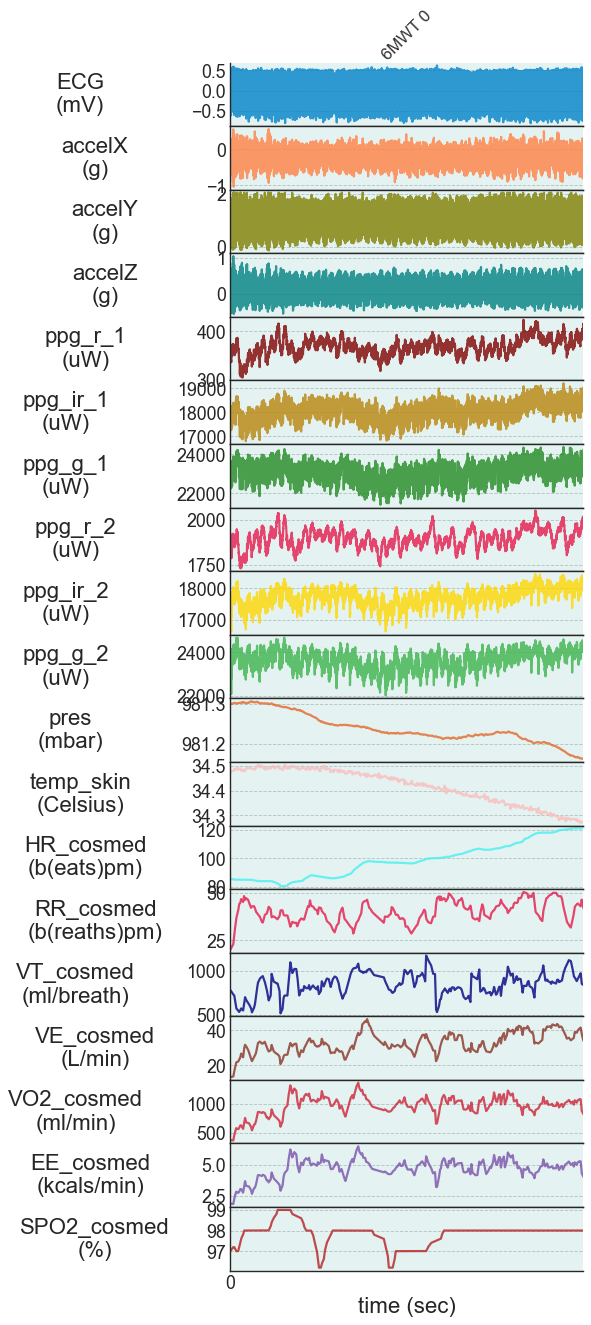

In [49]:
plot_all_sync(df, subject_id, outputdir=outputdir, show_plot=True)

In [50]:
hr = df['HR_cosmed'].values
ECG = df['ECG'].values
Fs = FS_RESAMPLE

QRS_detector_dict = detect_QRS(hr, ECG, Fs)
1-QRS_detector_dict['N_kept']/QRS_detector_dict['N_detected']

	 use S peaks


0.0

In [51]:
QRS_detector_dict['N_kept'], QRS_detector_dict['N_detected']

(592, 592)

# inspect detected R peaksm

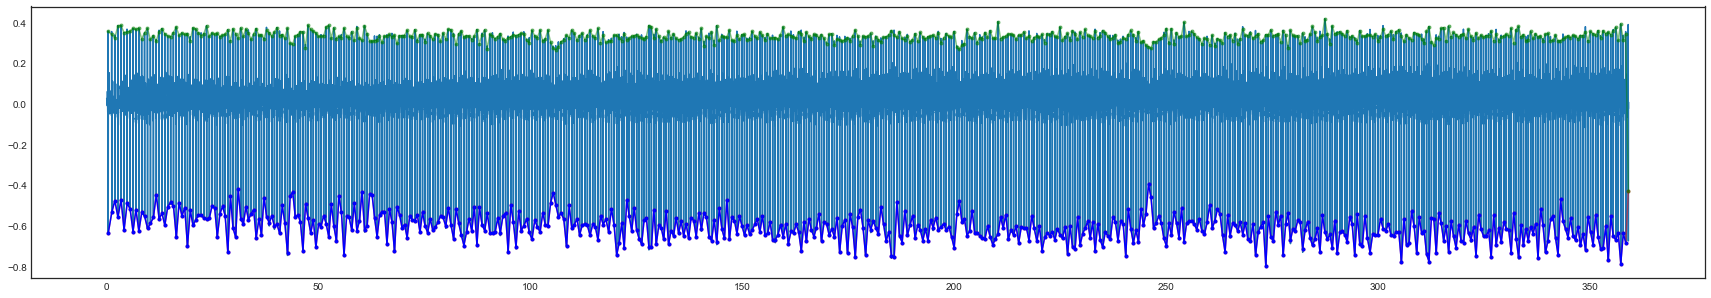

In [52]:
fig, ax = plt.subplots(figsize=(30, 5))
ecg_dict = QRS_detector_dict['ecg_dict']
i_R_peaks = QRS_detector_dict['i_R_peaks']
i_S_peaks = QRS_detector_dict['i_S_peaks']
i_beat_peaks = QRS_detector_dict['i_beat_peaks']

ax.plot(np.arange(ecg_dict['ecg_filt1'].shape[0])/Fs, ecg_dict['ecg_filt1'])
ax.plot(i_S_peaks/Fs, ecg_dict['ecg_filt1'][i_S_peaks], marker='.', color='r', alpha=0.5)
ax.plot(i_R_peaks/Fs, ecg_dict['ecg_filt1'][i_R_peaks], marker='.', color='g', alpha=0.5)
ax.plot(i_beat_peaks/Fs, ecg_dict['ecg_filt1'][i_beat_peaks], marker='.', color='blue')
# ax.set_xlim(10,49)

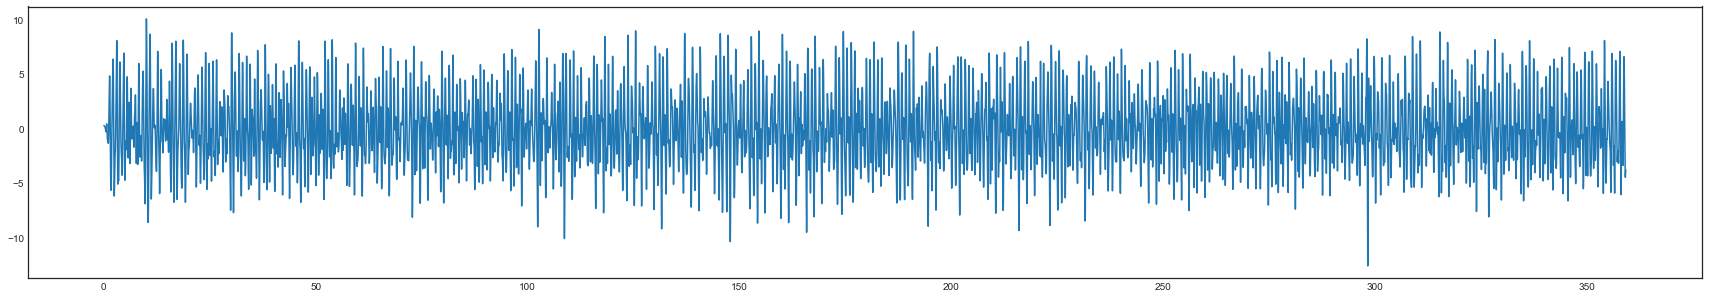

In [53]:
fig, ax = plt.subplots(figsize=(30, 5))
# ecg_dict = QRS_detector_dict['ecg_dict']
# i_R_peaks = QRS_detector_dict['i_R_peaks']
# i_S_peaks = QRS_detector_dict['i_S_peaks']
# i_beat_peaks = QRS_detector_dict['i_beat_peaks']
ppg = get_filt_df(df, Fs)['ppg_r_1'].values

ax.plot(np.arange(ppg.shape[0])/Fs, ppg)

# ax.plot(i_R_peaks/Fs, ecg_dict['ecg_filt1'][i_R_peaks]*100+75, marker='.', color='r', alpha=0.5)

# ax.set_xlim(10,49)# ax.set_ylim(-100,100)

# segment the beats and put them in nested dict
TODO: modify **df_sub_BH_lead = df_sub[i_BH_start+nadir_offset:i_BH_end+nadir_offset]**
so its starting point is BH_start
 

In [54]:

beats_dict = segment_df(get_filt_df(df, Fs).copy(), QRS_detector_dict, Fs)
use_ensemble = True


if use_ensemble:
    for key in beats_dict:
        if 'ppg' not in key:
            continue
        sig_beats = beats_dict[key]
        beats_dict[key] = get_ensemble_beats(sig_beats, N_enBeats=4, use_woody=False)


In [55]:
# beats_dict

In [56]:
# from importlib import reload

# %load_ext autoreload
# %autoreload 2

# label_range_dict

# plot the beats

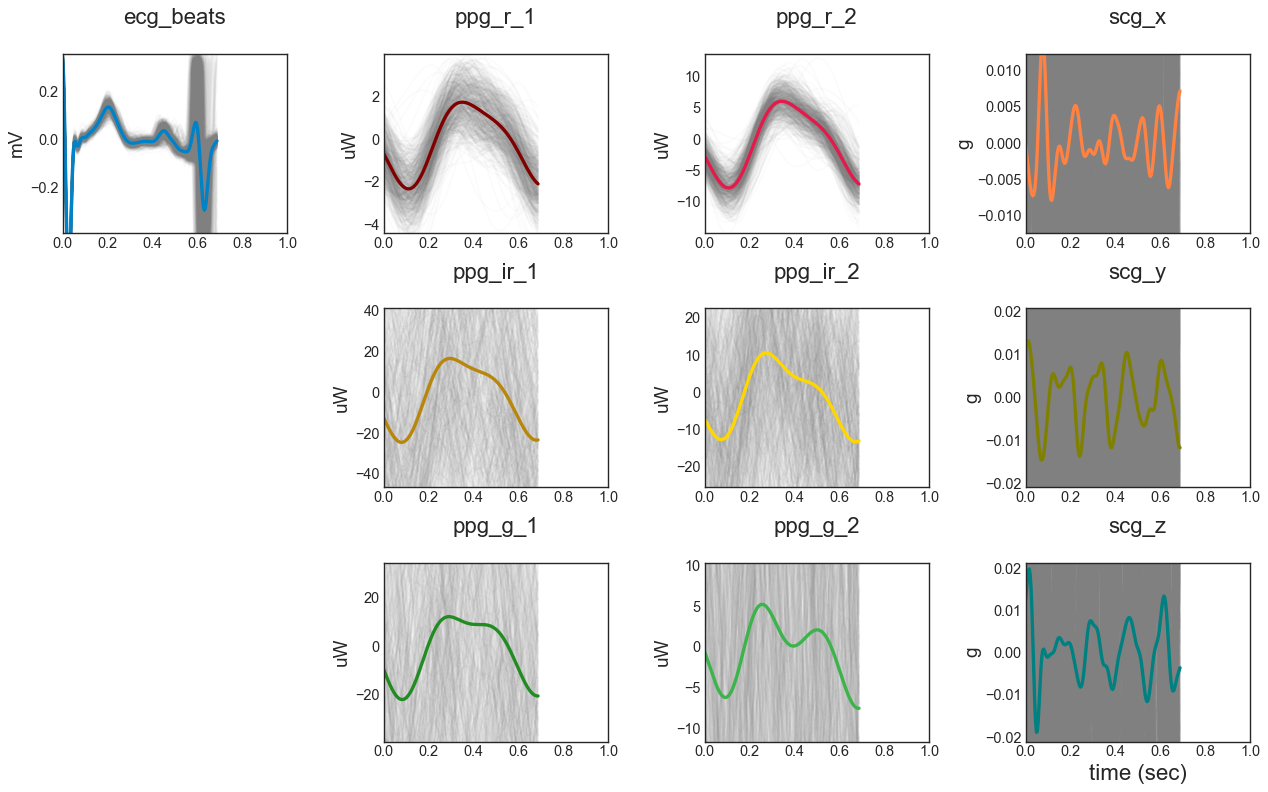

In [57]:
beats_id = [1, 10, 2, 6, 11, 3, 7, 4, 8, 12, 0]
# subject_id = df['subject_id'].unique()[0]

plot_ALL_beats(beats_dict, beats_id, subject_id, Fs, fig_name='all', outputdir=outputdir+subject_id+'/', show_plot=True)

ppg_g_1 0.5576271186440678
ppg_r_1 0.07288135593220335
ppg_ir_1 0.5118644067796609
ppg_g_2 0.6050847457627119
ppg_r_2 0.04406779661016946
ppg_ir_2 0.5254237288135593


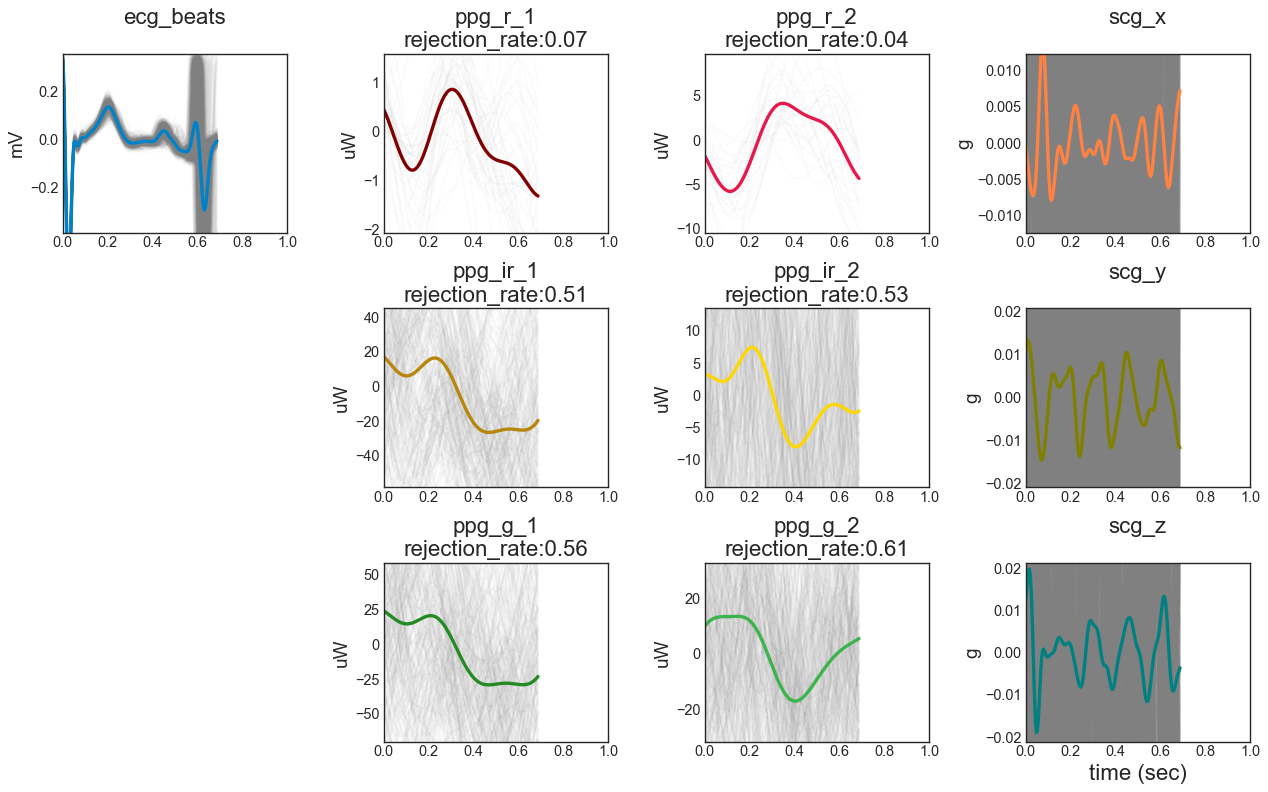

In [58]:
plot_ALL_beats(beats_dict, beats_id, subject_id, Fs, remove_ol=True, fig_name='bad', outputdir=outputdir+subject_id+'/', show_plot=True)

ppg_g_1 0.5576271186440678
ppg_r_1 0.07288135593220335
ppg_ir_1 0.5118644067796609
ppg_g_2 0.6050847457627119
ppg_r_2 0.04406779661016946
ppg_ir_2 0.5254237288135593


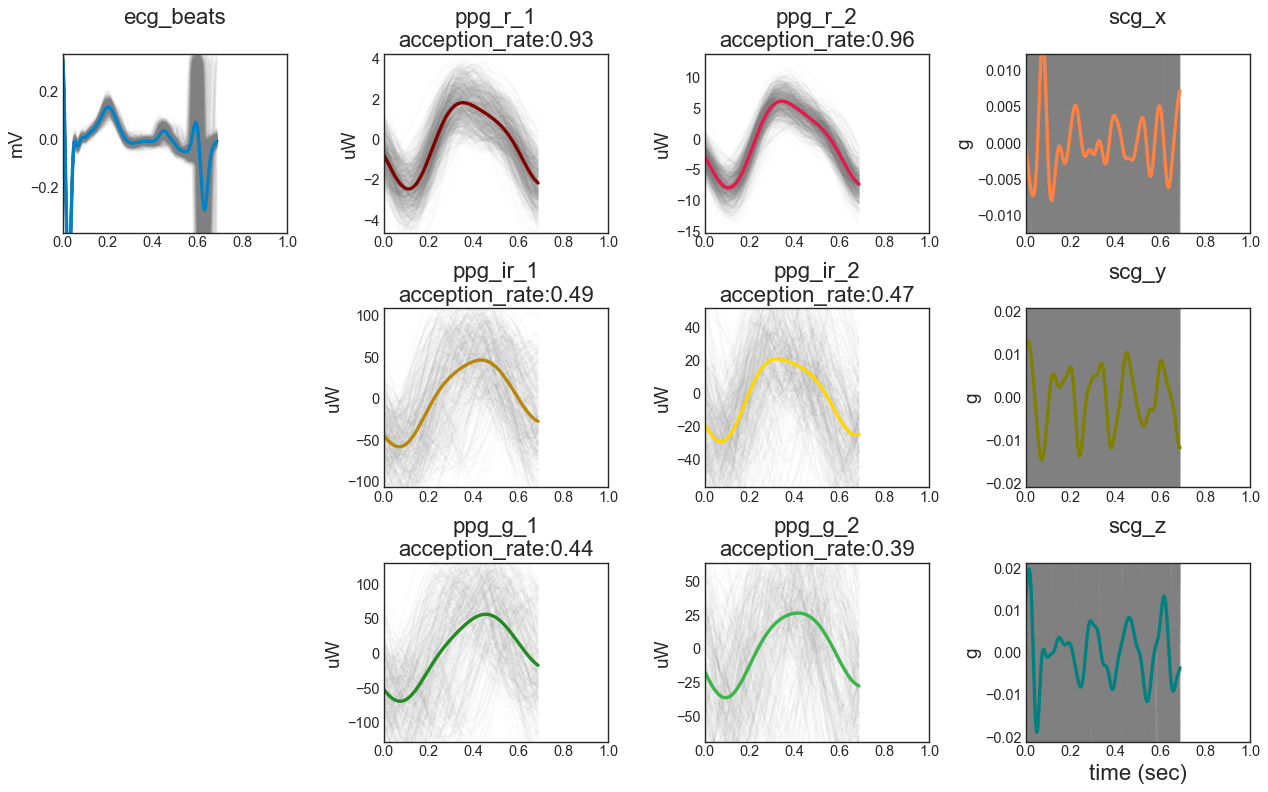

In [59]:
plot_ALL_beats(beats_dict, beats_id, subject_id, Fs, remove_ol=False, fig_name='good', outputdir=outputdir+subject_id+'/', show_plot=True)

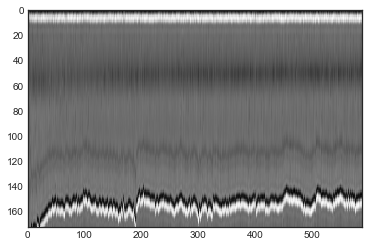

In [60]:
plt.imshow(beats_dict['ecg_beats'], interpolation='nearest', aspect='auto')
plt.show()

In [61]:
# plt.imshow(beats_dict['scg_z'])
# plt.show()

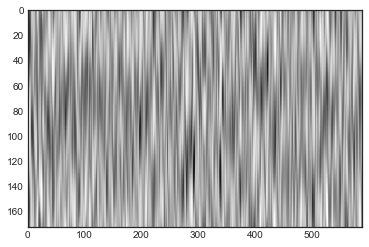

In [62]:
beats = beats_dict['ppg_ir_2'].copy()

plt.imshow(beats, interpolation='nearest', aspect='auto')
plt.show()

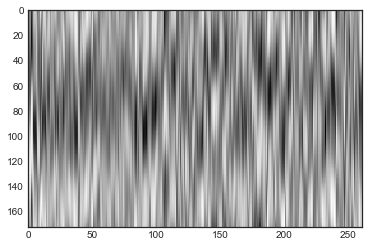

In [63]:
template = beats_dict['ppg_ir_2'][:,:50].mean(axis=1)
mask_all, ol_rate = clean_PPG(beats, template, Fs)
# beats = beats[:, mask_all]
ol_rate
# print(beat_name, ol_rate)
# ax.set_title(beat_name+'\nol_rate:{:.2f}'.format(1-ol_rate), fontsize=fontsize)
# beats = beats_dict['ppg_r_1']

plt.imshow(beats[:, mask_all], interpolation='nearest', aspect='auto')
plt.show()


In [64]:
unit_dict

{'accel': 'g',
 'ppg': 'uW',
 'temp': 'Celsius',
 'pres': 'mbar',
 'ecg': 'mV',
 'HR': 'b(eats)pm',
 'RR': 'b(reaths)pm',
 'VT': 'ml/breath',
 'VE': 'L/min',
 'VO2': 'ml/min',
 'VCO2': 'ml/min',
 'EE': 'kcals/min',
 'SPO2': '%'}

In [65]:
label_range_dict

{'ppg': [-100, 100],
 'acc': [-2, 2],
 'ecg': [-5, 5],
 'RR': [5, 100],
 'HR': [40, 180],
 'rer': [0.4, 1.0],
 'vevco2_slope': [20, 50],
 'VT': [1, 10000],
 'SPO2': [70, 100],
 'width_QRS': 0.15,
 'VE': [0, 200],
 'VO2': [0, 6000],
 'VCO2': [0, 6000],
 'EE': [0, 30000],
 'GpsAlt': [1, 2000],
 'AmbTemp': [-10, 35]}

In [66]:

def inspect_variable_dist(variable_data, label_name, outputdir=None, show_plot=False):

#     label_name = 'SpO2'
#     SpO2 = biopac_dict['SpO2']

    fig=plt.figure(figsize=(5, 5), dpi= 80, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(1, 1, 1)


    ax.hist(variable_data, 11, alpha=0.5, label='{}'.format(label_name))
    ax.set_ylabel('count', fontsize = 20)
    ax.set_xlabel(label_name+'\n'+unit_dict[label_name.split('_')[0]], fontsize = 20)
#     ax.set_title(r'$SpO_{2}$ (1 subject, 3 breath-holds)  ', fontsize = 20)
    ax.tick_params(axis='x', which='major', labelsize=15)
#     ax.set_xticks(range(100))
#     ax.xaxis.set_major_locator(MaxNLocator(integer=True))

#     ax.set_xlim(label_range_dict[label_name.split('_')[0]])

    fig.tight_layout()
    
#     fig_name = '[sub {}] SpO2 dist.'.format(biopac_dict['subject_id'])
#     if log_wandb:
#         wandb.log({fig_name: wandb.Image(fig)})
# #         wandb.log({fig_name: fig})
        
        
#     if outputdir is not None:
#         if not os.path.exists(outputdir):
#             os.makedirs(outputdir)
#         fig.savefig(outputdir + 'SpO2_dist_{}.png'.format(biopac_dict['subject_id']), facecolor=fig.get_facecolor())

#     if show_plot == False:
#         plt.close(fig)
#         pyplot.close(fig)
#         plt.close('all')


In [67]:
label_name
unit_dict

NameError: name 'label_name' is not defined

HR_cosmed
RR_cosmed
VT_cosmed
VE_cosmed
VO2_cosmed
VCO2_cosmed
EE_cosmed
SPO2_cosmed
GpsAlt_cosmed


KeyError: 'GpsAlt'

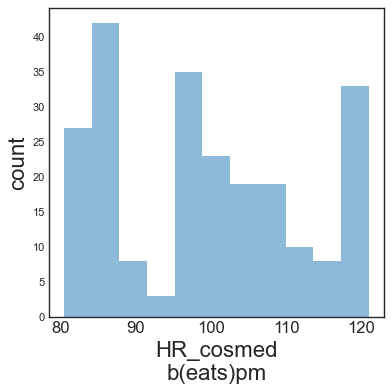

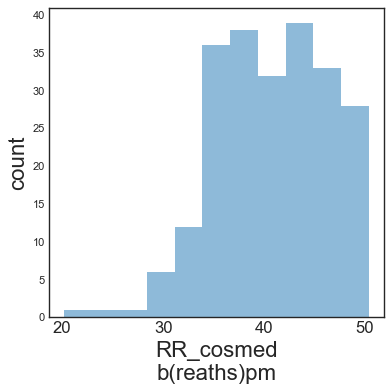

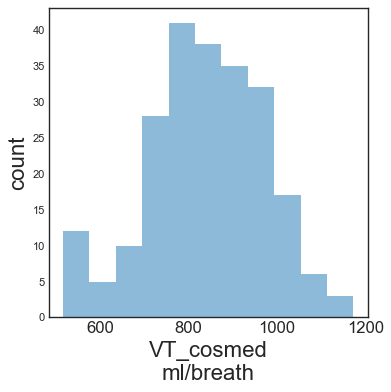

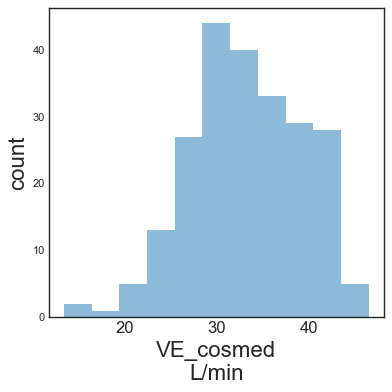

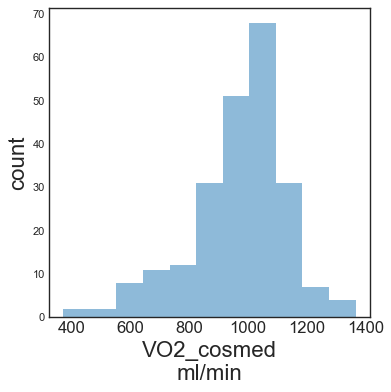

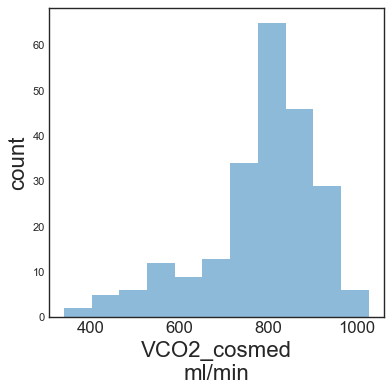

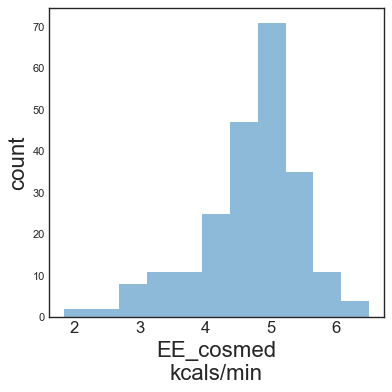

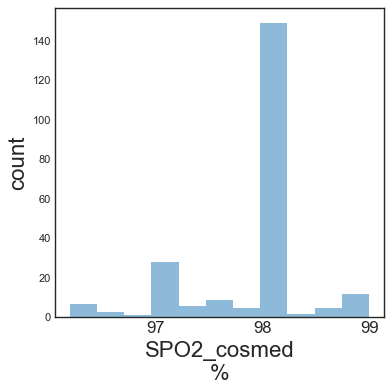

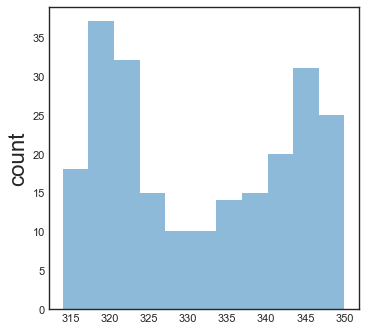

In [68]:

# for biopac_dict in list_biopac_clean:

for label_name in df.columns:
    if 'cosmed' in label_name:
        print(label_name)
# label_name = 'HR_cosmed'
        variable_data = df[df['Sampled_cosmed']==1][label_name]

        inspect_variable_dist(variable_data, label_name, outputdir=outputdir)